# Setup Notebook

In [119]:
import warnings
warnings.filterwarnings("ignore")

# Load Requirements
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix

In [3]:
# Load Data
dtype_users = {
    'object_id': str, 
    'creation_time': str, 
    'name': str, 
    'email':str, 
    'creation_source': 'category',
    'last_session_creation_time': str, 
    'opted_in_to_mailing_list': 'category',
    'enabled_for_marketing_drip': 'category', 
    'org_id': str, 
    'invited_by_user_id': str
}

dtype_user_engagement = {
    'time_stamp': str, 
    'user_id': str, 
    'visited': int
}

users = pd.read_csv('takehome_users.csv', encoding='windows-1252', dtype=dtype_users)
user_engagement = pd.read_csv('takehome_user_engagement.csv', dtype=dtype_user_engagement)

In [4]:
print(users.head(5))

  object_id        creation_time               name  \
0         1  2014-04-22 03:53:30     Clausen August   
1         2  2013-11-15 03:45:04      Poole Matthew   
2         3  2013-03-19 23:14:52  Bottrill Mitchell   
3         4  2013-05-21 08:09:28    Clausen Nicklas   
4         5  2013-01-17 10:14:20          Raw Grace   

                        email creation_source last_session_creation_time  \
0    AugustCClausen@yahoo.com    GUEST_INVITE                 1398138810   
1      MatthewPoole@gustr.com      ORG_INVITE                 1396237504   
2  MitchellBottrill@gustr.com      ORG_INVITE                 1363734892   
3   NicklasSClausen@yahoo.com    GUEST_INVITE                 1369210168   
4          GraceRaw@yahoo.com    GUEST_INVITE                 1358849660   

   opted_in_to_mailing_list  enabled_for_marketing_drip org_id  \
0                         1                           0     11   
1                         0                           0      1   
2             

In [5]:
print(user_engagement.head(5))

            time_stamp user_id  visited
0  2014-04-22 03:53:30       1        1
1  2013-11-15 03:45:04       2        1
2  2013-11-29 03:45:04       2        1
3  2013-12-09 03:45:04       2        1
4  2013-12-25 03:45:04       2        1


# Preprocess Data for Analysis

In [6]:
# Convert creation_time and last_session_creation_time to datetime
users['creation_time'] = pd.to_datetime(users['creation_time'])
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s')

# Convert time_stamp to datetime
user_engagement['time_stamp'] = pd.to_datetime(user_engagement['time_stamp']).dt.date

In [7]:
# Label users

def did_user_adopt(user_id, user_engagement):
    """
    Return boolean adopted: True if user has logged in 3 times in 7 day period, False otherwise
    
    param str user_id: user id
    param dataframe user_engagement: timestamp of all times user visited
    """
    
    # filter user_engagement to just the specific user (user_id)
    user_id_engagements = user_engagement[user_engagement['user_id']==user_id].sort_values('time_stamp')
    
    # return False if user has not logged in at least three times
    if user_id_engagements['visited'].sum() < 3:
        adopted = False
        return adopted
    
    # loop through user_id_engagements to identify whether user has logged in 3 times within 7 day period
    for index, row in user_id_engagements.iterrows():
        start_date = row['time_stamp']
        end_date = start_date + dt.timedelta(days=7)
        total_visits = user_id_engagements.loc[
            (user_id_engagements['time_stamp'] >= start_date) & 
            (user_id_engagements['time_stamp'] < end_date),
            'visited'
        ].sum()
        if total_visits >= 3:
            adopted = True
            return adopted
            
    # if users do not have a 7 day period with 3 or more logins, then they aren't adopters
    adopted = False
    return adopted

users['adopted'] = users['object_id'].apply(lambda x: did_user_adopt(x, user_engagement))

# Explore Features

### How many values (and missing values) are there?

In [8]:
users.count()

object_id                     12000
creation_time                 12000
name                          12000
email                         12000
creation_source               12000
last_session_creation_time     8823
opted_in_to_mailing_list      12000
enabled_for_marketing_drip    12000
org_id                        12000
invited_by_user_id             6417
adopted                       12000
dtype: int64

Observations:
- A little more than half of the users were invited by another user.
- About 3,200 users have never logged in.

### How many unique values are there for each column?

In [9]:
users.nunique()

object_id                     12000
creation_time                 11996
name                          11355
email                         11980
creation_source                   5
last_session_creation_time     8821
opted_in_to_mailing_list          2
enabled_for_marketing_drip        2
org_id                          417
invited_by_user_id             2564
adopted                           2
dtype: int64

Observations:
- creation_source, opted_in_to_mailing_list, enabled_for_marketing_drip, org_id are clearly categorical columns.
- Less than a fourth of users participate in inviting other users
- Some emails have multiple accounts.

### Feature Exploration

#### creation_time

In [10]:
users['creation_time'].describe()

count                   12000
unique                  11996
top       2014-02-11 17:57:53
freq                        2
first     2012-05-31 00:43:27
last      2014-05-30 23:59:19
Name: creation_time, dtype: object

In [11]:
# Extract quarter and year from datetime
# https://stackoverflow.com/questions/31441514/datetime-format-in-quarters
def convert_to_quarter(d):
    ts = pd.Timestamp(pd.to_datetime(d,format='%Y%m'))
    return "{}Q{}".format(ts.year, ts.quarter)

users['creation_quarter'] = users['creation_time'].apply(lambda x: convert_to_quarter(x))

<BarContainer object of 9 artists>

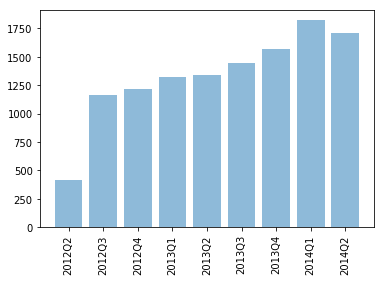

In [12]:
# Plot quarterly new users
objects = sorted(users['creation_quarter'].unique())
y_pos = np.arange(len(objects))
performance = users.groupby('creation_quarter')['object_id'].count()
plt.xticks(y_pos, objects, rotation=90)

plt.bar(y_pos, performance, align='center', alpha=0.5)

Observations:
- New users are consistently joining and growing each quarter.
- Full data for 2014Q2 and 2012Q2 are not available.

<BarContainer object of 9 artists>

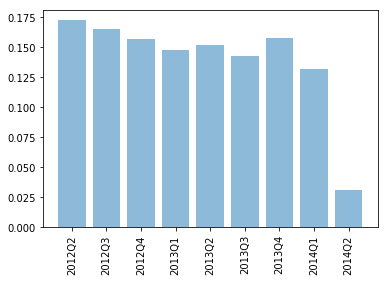

In [13]:
# Plot proportion of users who adopted from each quarter
objects = sorted(users['creation_quarter'].unique())
y_pos = np.arange(len(objects))
performance = users.groupby('creation_quarter')['adopted'].mean()
plt.xticks(y_pos, objects, rotation=90)

plt.bar(y_pos, performance, align='center', alpha=0.5)

In [14]:
#https://towardsdatascience.com/running-chi-square-tests-in-python-with-die-roll-data-b9903817c51b
table = pd.crosstab(users['adopted'], users['creation_quarter'])
chi2_stat, p_val, dof, ex = stats.chi2_contingency(table)
print("===Chi2 Stat===")
print(chi2_stat)
print("\n")
print("===Degrees of Freedom===")
print(dof)
print("\n")
print("===P-Value===")
print(p_val)
print("\n")
print("===Contingency Table===")
print(ex)

===Chi2 Stat===
191.5815646466752


===Degrees of Freedom===
8


===P-Value===
3.7851454828665135e-37


===Contingency Table===
[[ 361.3305 1006.0065 1056.2635 1142.9135 1162.843  1251.226  1361.2715
  1577.8965 1478.249 ]
 [  55.6695  154.9935  162.7365  176.0865  179.157   192.774   209.7285
   243.1035  227.751 ]]


#### days_from_creation

In [79]:
def calc_days_from_creation(creation_time):
    baseline_date = dt.date(2014, 6, 6)
    creation_date = creation_time.date()
    days_from_creation = baseline_date - creation_date
    days_from_creation = days_from_creation.days
    return days_from_creation

users['days_from_creation'] = users['creation_time'].apply(lambda x: calc_days_from_creation(x))

In [80]:
users['days_from_creation'].describe()

count    12000.000000
mean       324.943167
std        216.641449
min          7.000000
25%        129.000000
50%        305.000000
75%        507.000000
max        736.000000
Name: days_from_creation, dtype: float64

(array([2011., 1438., 1275., 1156., 1117., 1079., 1068.,  980.,  956.,
         920.]),
 array([  7. ,  79.9, 152.8, 225.7, 298.6, 371.5, 444.4, 517.3, 590.2,
        663.1, 736. ]),
 <a list of 10 Patch objects>)

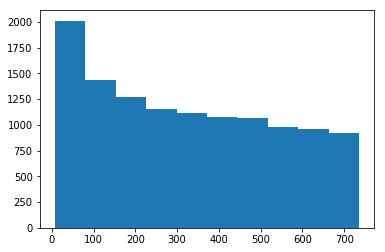

In [81]:
plt.hist(users['days_from_creation'])

In [82]:
sample_adopted = users.loc[users['adopted']==True, 'days_from_creation'].dropna().sample(30)
sample_non_adopted = users.loc[users['adopted']==False, 'days_from_creation'].dropna().sample(30)

t, p_val = stats.ttest_ind(sample_adopted, sample_non_adopted, equal_var=False)

print("===t Stat===")
print(t)
print("\n")
print("===P-Value===")
print(p_val)

===t Stat===
2.3446120047354353


===P-Value===
0.022632695453039326


#### creation_source

In [18]:
users['creation_source'].describe()

count          12000
unique             5
top       ORG_INVITE
freq            4254
Name: creation_source, dtype: object

<BarContainer object of 5 artists>

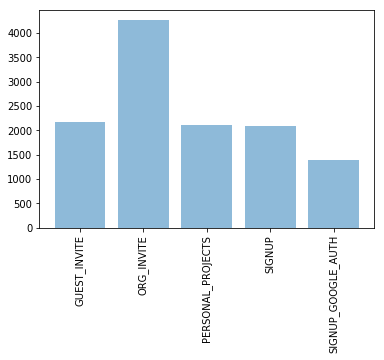

In [15]:
# Plot creation_source
objects = sorted(users['creation_source'].unique())
y_pos = np.arange(len(objects))
performance = users.groupby('creation_source')['object_id'].count()
plt.xticks(y_pos, objects, rotation=90)

plt.bar(y_pos, performance, align='center', alpha=0.5)

In [16]:
#https://towardsdatascience.com/running-chi-square-tests-in-python-with-die-roll-data-b9903817c51b
table = pd.crosstab(users['adopted'], users['creation_source'])
chi2_stat, p_val, dof, ex = stats.chi2_contingency(table)
print("===Chi2 Stat===")
print(chi2_stat)
print("\n")
print("===Degrees of Freedom===")
print(dof)
print("\n")
print("===P-Value===")
print(p_val)
print("\n")
print("===Contingency Table===")
print(ex)

===Chi2 Stat===
92.28463976593646


===Degrees of Freedom===
4


===P-Value===
4.305821709002437e-19


===Contingency Table===
[[1874.2395 3686.091  1829.1815 1808.3855 1200.1025]
 [ 288.7605  567.909   281.8185  278.6145  184.8975]]


#### last_session_creation_time

In [17]:
users['last_session_creation_time'].describe()

count                    8823
unique                   8821
top       2014-06-04 21:21:37
freq                        2
first     2012-05-31 08:20:06
last      2014-06-06 14:58:50
Name: last_session_creation_time, dtype: object

In [22]:
user_engagement['time_stamp'].max()

datetime.date(2014, 6, 6)

In [36]:
user_engagement['time_stamp'].min()

datetime.date(2012, 5, 31)

In [40]:
def calc_days_from_last_session(last_session_creation_time):
    baseline_date = dt.date(2014, 6, 6)
    last_session_creation_date = last_session_creation_time.date()
    days_from_last_session = baseline_date - last_session_creation_date
    days_from_last_session = days_from_last_session.days
    return days_from_last_session

users['days_from_last_session'] = users['last_session_creation_time'].apply(lambda x: calc_days_from_last_session(x))

In [41]:
users['days_from_last_session'].describe()

count    8823.000000
mean      263.622351
std       226.052501
min         0.000000
25%        42.000000
50%       222.000000
75%       450.000000
max       736.000000
Name: days_from_last_session, dtype: float64

(array([2688.,  935.,  776.,  758.,  690.,  695.,  645.,  575.,  564.,
         497.]),
 array([  0. ,  73.6, 147.2, 220.8, 294.4, 368. , 441.6, 515.2, 588.8,
        662.4, 736. ]),
 <a list of 10 Patch objects>)

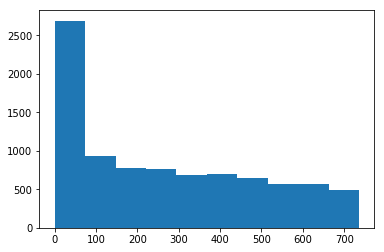

In [46]:
plt.hist(users['days_from_last_session'].dropna())

In [50]:
sample_adopted = users.loc[users['adopted']==True, 'days_from_last_session'].dropna().sample(30)
sample_non_adopted = users.loc[users['adopted']==False, 'days_from_last_session'].dropna().sample(30)

t, p_val = stats.ttest_ind(sample_adopted, sample_non_adopted, equal_var=False)

print("===t Stat===")
print(t)
print("\n")
print("===P-Value===")
print(p_val)

===t Stat===
-5.004633634139786


===P-Value===
1.1897983451176552e-05


#### last_session_quarter

In [87]:
users['last_session_quarter'] = users['last_session_creation_time'].apply(lambda x: convert_to_quarter(x))
users.loc[users['last_session_quarter'] == 'nanQnan', 'last_session_quarter'] = np.nan

In [88]:
users['last_session_quarter'].describe()

count       8823
unique         9
top       2014Q2
freq        2596
Name: last_session_quarter, dtype: object

In [90]:
users['last_session_quarter'].unique()

array(['2014Q2', '2014Q1', '2013Q1', '2013Q2', '2013Q4', '2012Q4', nan,
       '2012Q3', '2013Q3', '2012Q2'], dtype=object)

<BarContainer object of 9 artists>

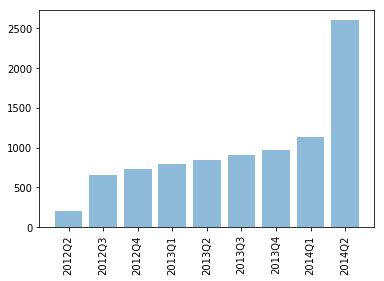

In [91]:
# Plot last_session_quarter
objects = sorted(users['last_session_quarter'].dropna().unique())
y_pos = np.arange(len(objects))
performance = users.groupby('last_session_quarter')['object_id'].count()
plt.xticks(y_pos, objects, rotation=90)

plt.bar(y_pos, performance, align='center', alpha=0.5)

<BarContainer object of 9 artists>

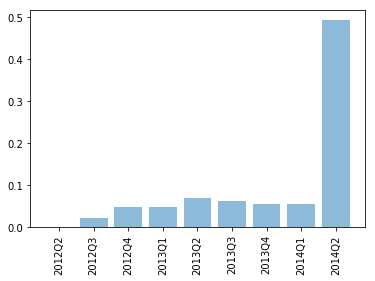

In [92]:
# Plot proportion of users who adopted
objects = sorted(users['last_session_quarter'].dropna().unique())
y_pos = np.arange(len(objects))
performance = users.groupby('last_session_quarter')['adopted'].mean()
plt.xticks(y_pos, objects, rotation=90)

plt.bar(y_pos, performance, align='center', alpha=0.5)

In [93]:
#https://towardsdatascience.com/running-chi-square-tests-in-python-with-die-roll-data-b9903817c51b
table = pd.crosstab(users['adopted'], users['last_session_quarter'])
chi2_stat, p_val, dof, ex = stats.chi2_contingency(table)
print("===Chi2 Stat===")
print(chi2_stat)
print("\n")
print("===Degrees of Freedom===")
print(dof)
print("\n")
print("===P-Value===")
print(p_val)
print("\n")
print("===Contingency Table===")
print(ex)

===Chi2 Stat===
2405.9699190357724


===Degrees of Freedom===
8


===P-Value===
0.0


===Contingency Table===
[[ 165.32267936  534.43420605  595.81638898  649.01428086  689.11730704
   742.31519891  790.60251615  929.73546413 2124.64195852]
 [  36.67732064  118.56579395  132.18361102  143.98571914  152.88269296
   164.68480109  175.39748385  206.26453587  471.35804148]]


#### logged_in
Based on last_session_creation_time. If user has not logged in, he or she would not have adopted.

In [53]:
users['logged_in'] = pd.isnull(users['last_session_creation_time']) == False

In [54]:
users['logged_in'].describe()

count     12000
unique        2
top        True
freq       8823
Name: logged_in, dtype: object

<BarContainer object of 2 artists>

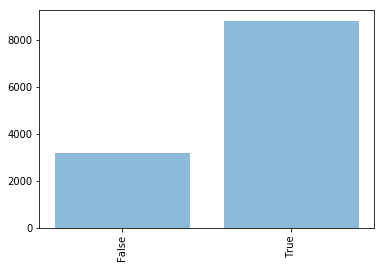

In [55]:
# Plot logged_in
objects = sorted(users['logged_in'].unique())
y_pos = np.arange(len(objects))
performance = users.groupby('logged_in')['object_id'].count()
plt.xticks(y_pos, objects, rotation=90)

plt.bar(y_pos, performance, align='center', alpha=0.5)

In [60]:
#https://towardsdatascience.com/running-chi-square-tests-in-python-with-die-roll-data-b9903817c51b
table = pd.crosstab(users['adopted'], users['logged_in'])
chi2_stat, p_val, dof, ex = stats.chi2_contingency(table)
print("===Chi2 Stat===")
print(chi2_stat)
print("\n")
print("===Degrees of Freedom===")
print(dof)
print("\n")
print("===P-Value===")
print(p_val)
print("\n")
print("===Contingency Table===")
print(ex)

===Chi2 Stat===
664.1563198257577


===Degrees of Freedom===
1


===P-Value===
1.8639790861651788e-146


===Contingency Table===
[[2752.8705 7645.1295]
 [ 424.1295 1177.8705]]


#### opted_in_to_mailing_list

In [58]:
users['opted_in_to_mailing_list'].describe()

count     12000
unique        2
top           0
freq       9006
Name: opted_in_to_mailing_list, dtype: int64

<BarContainer object of 2 artists>

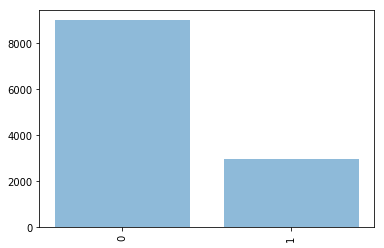

In [59]:
# Plot opted_in_to_mailing_list
objects = sorted(users['opted_in_to_mailing_list'].unique())
y_pos = np.arange(len(objects))
performance = users.groupby('opted_in_to_mailing_list')['object_id'].count()
plt.xticks(y_pos, objects, rotation=90)

plt.bar(y_pos, performance, align='center', alpha=0.5)

In [61]:
#https://towardsdatascience.com/running-chi-square-tests-in-python-with-die-roll-data-b9903817c51b
table = pd.crosstab(users['adopted'], users['opted_in_to_mailing_list'])
chi2_stat, p_val, dof, ex = stats.chi2_contingency(table)
print("===Chi2 Stat===")
print(chi2_stat)
print("\n")
print("===Degrees of Freedom===")
print(dof)
print("\n")
print("===P-Value===")
print(p_val)
print("\n")
print("===Contingency Table===")
print(ex)

===Chi2 Stat===
0.7327718655131716


===Degrees of Freedom===
1


===P-Value===
0.3919861918708256


===Contingency Table===
[[7803.699 2594.301]
 [1202.301  399.699]]


#### enabled_for_marketing_drip

In [64]:
users['enabled_for_marketing_drip'].describe()

count     12000
unique        2
top           0
freq      10208
Name: enabled_for_marketing_drip, dtype: int64

<BarContainer object of 2 artists>

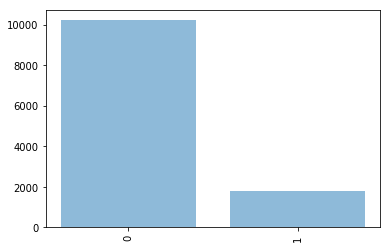

In [65]:
# Plot enabled_for_marketing_drip
objects = sorted(users['enabled_for_marketing_drip'].unique())
y_pos = np.arange(len(objects))
performance = users.groupby('enabled_for_marketing_drip')['object_id'].count()
plt.xticks(y_pos, objects, rotation=90)

plt.bar(y_pos, performance, align='center', alpha=0.5)

In [66]:
#https://towardsdatascience.com/running-chi-square-tests-in-python-with-die-roll-data-b9903817c51b
table = pd.crosstab(users['adopted'], users['enabled_for_marketing_drip'])
chi2_stat, p_val, dof, ex = stats.chi2_contingency(table)
print("===Chi2 Stat===")
print(chi2_stat)
print("\n")
print("===Degrees of Freedom===")
print(dof)
print("\n")
print("===P-Value===")
print(p_val)
print("\n")
print("===Contingency Table===")
print(ex)

===Chi2 Stat===
0.22279770974709384


===Degrees of Freedom===
1


===P-Value===
0.6369164225605993


===Contingency Table===
[[8845.232 1552.768]
 [1362.768  239.232]]


#### org_id

In [67]:
users['org_id'].describe()

count     12000
unique      417
top           0
freq        319
Name: org_id, dtype: object

<BarContainer object of 417 artists>

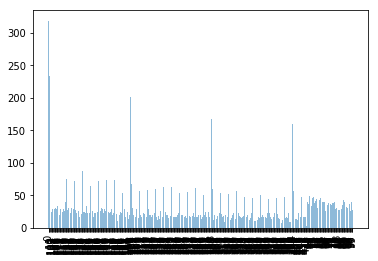

In [69]:
# Plot org_id
objects = sorted(users['org_id'].unique())
y_pos = np.arange(len(objects))
performance = users.groupby('org_id')['object_id'].count()
plt.xticks(y_pos, objects, rotation=90)

plt.bar(y_pos, performance, align='center', alpha=0.5)

In [71]:
#https://towardsdatascience.com/running-chi-square-tests-in-python-with-die-roll-data-b9903817c51b
table = pd.crosstab(users['adopted'], users['org_id'])
chi2_stat, p_val, dof, ex = stats.chi2_contingency(table)
print("===Chi2 Stat===")
print(chi2_stat)
print("\n")
print("===Degrees of Freedom===")
print(dof)
print("\n")
print("===P-Value===")
print(p_val)

===Chi2 Stat===
539.0103037900813


===Degrees of Freedom===
416


===P-Value===
4.297528245467555e-05


#### invited_by_user_id 

In [72]:
users['invited_by_user_id'].describe()

count      6417
unique     2564
top       10741
freq         13
Name: invited_by_user_id, dtype: object

In [74]:
#https://towardsdatascience.com/running-chi-square-tests-in-python-with-die-roll-data-b9903817c51b
table = pd.crosstab(users['adopted'], users['invited_by_user_id'])
chi2_stat, p_val, dof, ex = stats.chi2_contingency(table)
print("===Chi2 Stat===")
print(chi2_stat)
print("\n")
print("===Degrees of Freedom===")
print(dof)
print("\n")
print("===P-Value===")
print(p_val)

===Chi2 Stat===
2618.8506299773953


===Degrees of Freedom===
2563


===P-Value===
0.21658492785300748


#### invited
Based on invited_by_user_id.

In [75]:
users['invited'] = pd.isnull(users['invited_by_user_id']) == False

In [76]:
users['invited'].describe()

count     12000
unique        2
top        True
freq       6417
Name: invited, dtype: object

<BarContainer object of 2 artists>

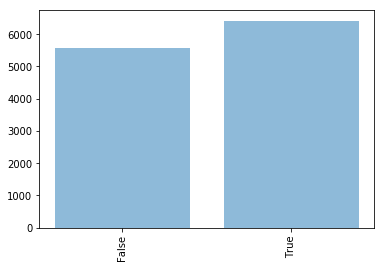

In [77]:
# Plot invited
objects = sorted(users['invited'].unique())
y_pos = np.arange(len(objects))
performance = users.groupby('invited')['object_id'].count()
plt.xticks(y_pos, objects, rotation=90)

plt.bar(y_pos, performance, align='center', alpha=0.5)

In [78]:
#https://towardsdatascience.com/running-chi-square-tests-in-python-with-die-roll-data-b9903817c51b
table = pd.crosstab(users['adopted'], users['invited'])
chi2_stat, p_val, dof, ex = stats.chi2_contingency(table)
print("===Chi2 Stat===")
print(chi2_stat)
print("\n")
print("===Degrees of Freedom===")
print(dof)
print("\n")
print("===P-Value===")
print(p_val)

===Chi2 Stat===
9.025572948110002


===Degrees of Freedom===
1


===P-Value===
0.0026622846583239388


# Build Model

In [98]:
features = [
    'creation_quarter',
    'days_from_creation',
    'creation_source',
    'last_session_quarter',
    'days_from_last_session',
    'logged_in',
    'org_id',
    'invited'
]

# features = [
#     'days_from_creation',
#     'creation_source',
#     'days_from_last_session',
#     'logged_in',
#     'org_id',
#     'invited'
# ]

# features = [
#     'creation_quarter',
#     'creation_source',
#     'last_session_quarter',
#     'logged_in',
#     'org_id',
#     'invited'
# ]

label = [
    'adopted'
]

X = pd.get_dummies(users[features])
y = users[label]

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=44)

In [115]:
clf = XGBClassifier()
clf.fit(X_train, y_train)
probabilities = clf.predict_proba(X_test)
predictions = clf.predict(X_test)
logloss_score = log_loss(y_test, probabilities)
accuracy = accuracy_score(y_test, predictions)

In [116]:
print('logloss:', logloss_score)
print('accuracy:', accuracy)

logloss: 0.07096463514017083
accuracy: 0.9741666666666666


In [123]:
true_negatives = confusion_matrix(y_test, predictions)[0,0]
false_negatives = confusion_matrix(y_test, predictions)[1,0]
true_positives = confusion_matrix(y_test, predictions)[1,1]
false_positives = confusion_matrix(y_test, predictions)[0,1]

print('true_negatives:', true_negatives)
print('false_negatives:', false_negatives)
print('true_positives:', true_positives)
print('false_positives:', false_positives)

true_negatives: 1035
false_negatives: 23
true_positives: 134
false_positives: 8
